# Project 2 — Part 5 Debug (Step-by-step): Matching → Homography → Pose (solvePnP)

המטרה של המחברת היא להבין **איזה שלב נשבר**:

## שלב A — Matching (פיצ'רים)
- מזהים features ברפרנס ובפריים
- עושים matching + ratio test
- אם אין מספיק התאמות איכותיות → אין טעם להמשיך

## שלב B — Homography (זה "מוצא את המישור" בתמונה)
- `cv2.findHomography(..., RANSAC)` מחזיר:
  - H + inlier_mask
- מה־H אנחנו מפיקים את **4 הקצוות בפריים** (המסגרת הכחולה)
- חשוב: זה *לא* משתמש ב־K/dist

## שלב C — Pose עם solvePnP (זה "ממקם את המישור ב־3D")
`solvePnP/solvePnPRansac` צריך התאמות **2D↔3D**:

- אופציה 1 (**מ־4 קצוות**):
  - 3D = 4 קצוות של מלבן במערכת צירים של המישור
  - 2D = 4 הקצוות מה־Homography

- אופציה 2 (**מ־inliers של matching** — מומלץ):
  - 3D = נקודות על המישור (Z=0) שמתקבלות ממיפוי הפיקסלים של הרפרנס ל־(x,y)
  - 2D = נקודות ה־inliers בפריים

במחברת אנחנו מציירים:
- **כחול** = המסגרת מה־Homography (שלב B)
- **ירוק/כתום** = reprojection של אותה מסגרת מה־pose (שלב C)

## איך עושים Debug נכון?
- אם הכחול לא יושב טוב → בעיה ב־matching/homography.
- אם הכחול טוב אבל הירוק/כתום רחוק → בעיה ב־pose (PnP), סקייל, או כיול (K/dist).



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def show(img_bgr, title=None, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()


def resolve_path(p: str) -> str:
    """Make relative paths work even if the notebook runs from the repo root."""
    pp = Path(p)
    candidates = [
        pp,
        Path.cwd() / pp,
        Path.cwd() / "augmented-reality-planar" / pp,
    ]
    for c in candidates:
        try:
            if c.exists():
                return str(c)
        except Exception:
            pass
    return str(pp)


def ratio_test(knn_pairs, ratio: float):
    good = []
    for p in knn_pairs:
        if len(p) < 2:
            continue
        m, n = p[0], p[1]
        if m.distance < float(ratio) * n.distance:
            good.append(m)
    return good


def make_centered_obj_plane(plane_w: float, plane_h: float) -> np.ndarray:
    hw, hh = float(plane_w) * 0.5, float(plane_h) * 0.5
    return np.array(
        [[-hw, -hh, 0.0], [hw, -hh, 0.0], [hw, hh, 0.0], [-hw, hh, 0.0]],
        dtype=np.float64,
    )



video: data\multi_plane_video.mp4
refs: ['data\\reference1.JPG', 'data\\reference2.JPG', 'data\\reference3.JPG']
frame size (w,h): (1920, 1080)
feature: SIFT


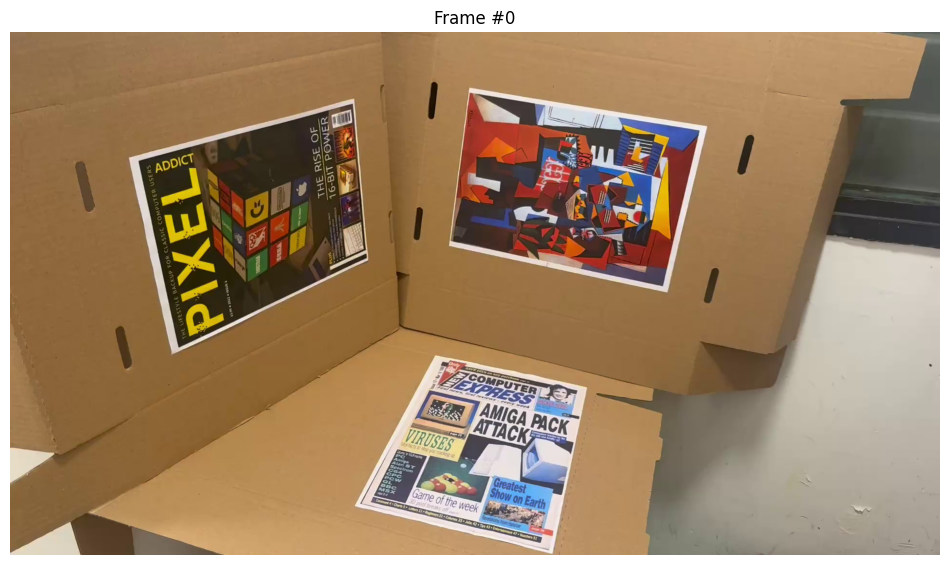

In [ ]:
# Inputs (use config.py as the single source of truth)
from config import Part5Config, get_camera_params_from_config

cfg = Part5Config()

FRAME_IDX = 0  # change freely

video_path = resolve_path(cfg.video_path)
ref_paths = [
    resolve_path(cfg.reference1_path),
    resolve_path(cfg.reference2_path),
    resolve_path(cfg.reference3_path),
]

refs = [cv2.imread(p) for p in ref_paths]
assert all(r is not None for r in refs), f"Failed to read one of: {ref_paths}"

cap = cv2.VideoCapture(video_path)
assert cap.isOpened(), f"Failed to open: {video_path}"

cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_IDX)
ok, frame = cap.read()
assert ok, f"Failed to read frame {FRAME_IDX}"

h, w = frame.shape[:2]
K, dist = get_camera_params_from_config((w, h), calib_output_path=cfg.calib_output_path)

print("video:", video_path)
print("refs:", ref_paths)
print("frame size (w,h):", (w, h))
print("feature:", cfg.feature_type)

show(frame, f"Frame #{FRAME_IDX}")



In [ ]:
# Feature detector + matcher (same feature type as the project)
feat = str(cfg.feature_type or "SIFT").upper().strip()
if feat == "SIFT":
    assert hasattr(cv2, "SIFT_create"), "SIFT not available. Install opencv-contrib-python or set feature_type='ORB'."
    det = cv2.SIFT_create()
    norm = cv2.NORM_L2
else:
    det = cv2.ORB_create(nfeatures=2000)
    norm = cv2.NORM_HAMMING

bf = cv2.BFMatcher(norm, crossCheck=False)

# Compute frame features ONCE
fr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
kp_fr, des_fr = det.detectAndCompute(fr_gray, None)
print("frame keypoints:", 0 if kp_fr is None else len(kp_fr))
print("frame desc:", None if des_fr is None else des_fr.shape)



frame keypoints: 5083
frame desc: (5083, 128)



Plane 1
[A] good matches = 463
[B] inliers = 229/463


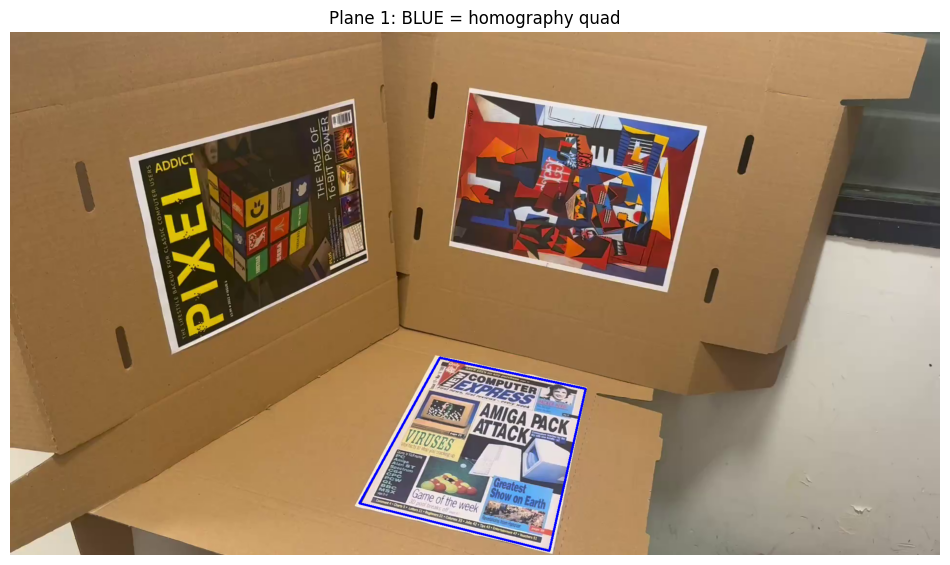

[C corners] ITERATIVE corner reproj err = 16.34px
[C corners] IPPE corner reproj err = 30.20px
[C inliers] ITERATIVE mean reproj err on inliers = 9.71px
[C inliers] IPPE mean reproj err on inliers = 8.52px


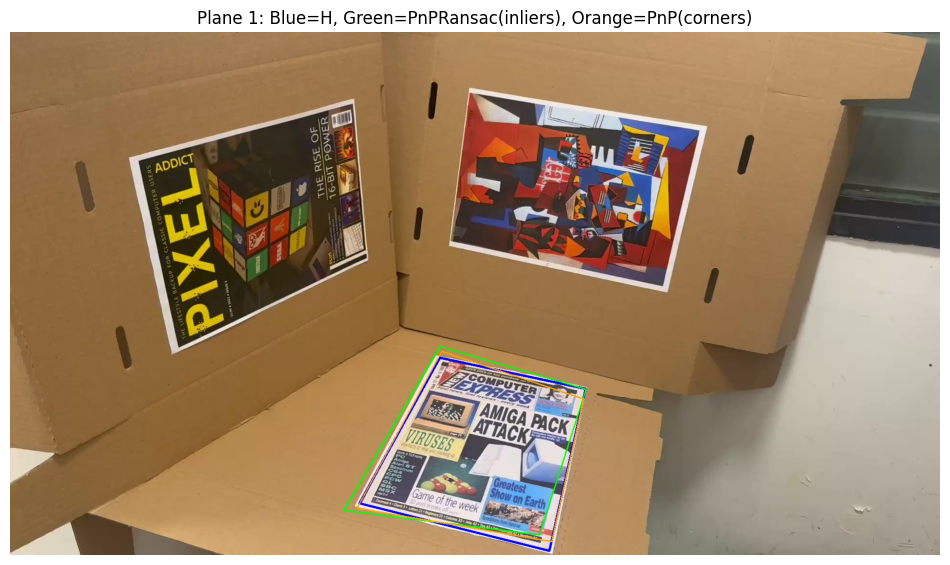


Plane 2
[A] good matches = 300
[B] inliers = 215/300


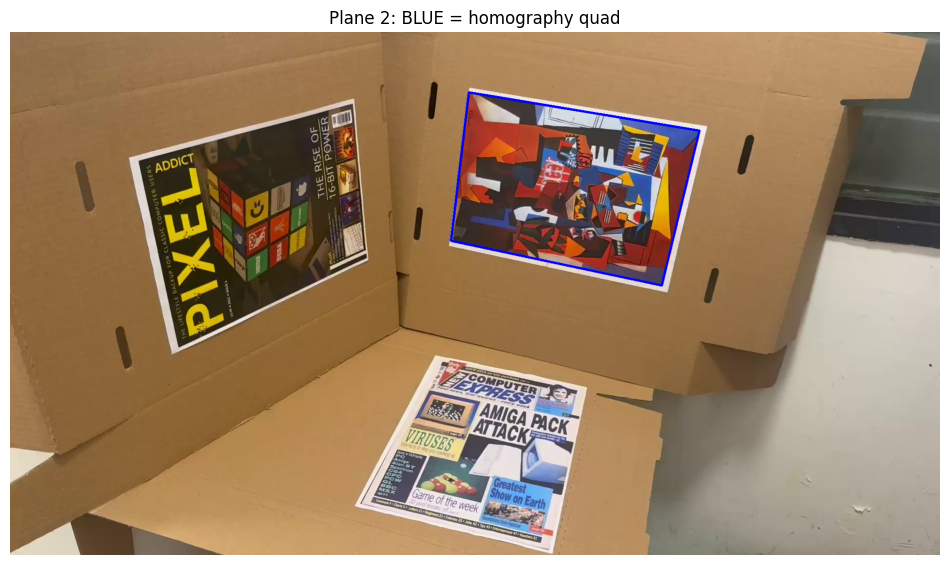

[C corners] ITERATIVE corner reproj err = 27.92px
[C corners] IPPE corner reproj err = 36.67px
[C inliers] ITERATIVE mean reproj err on inliers = 11.87px
[C inliers] IPPE mean reproj err on inliers = 7.80px


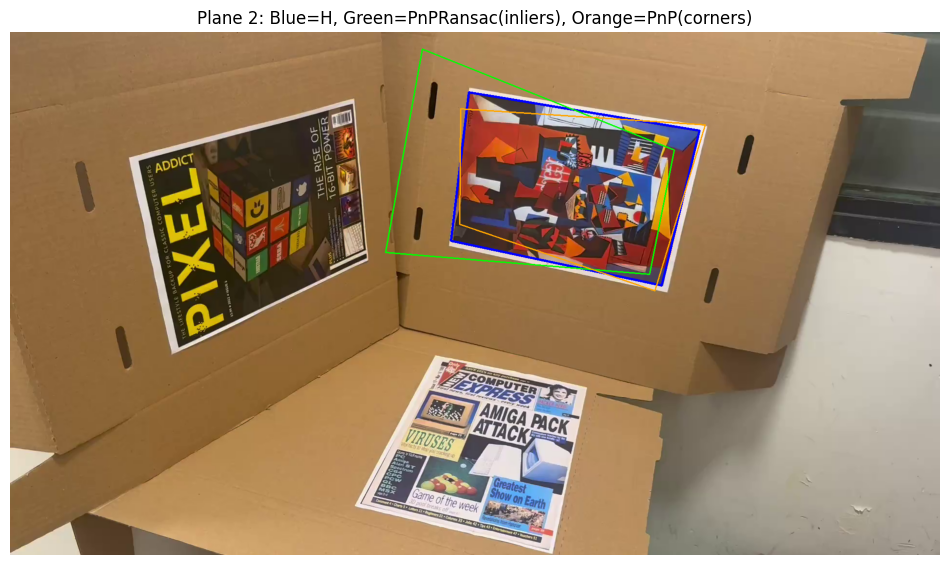


Plane 3
[A] good matches = 396
[B] inliers = 176/396


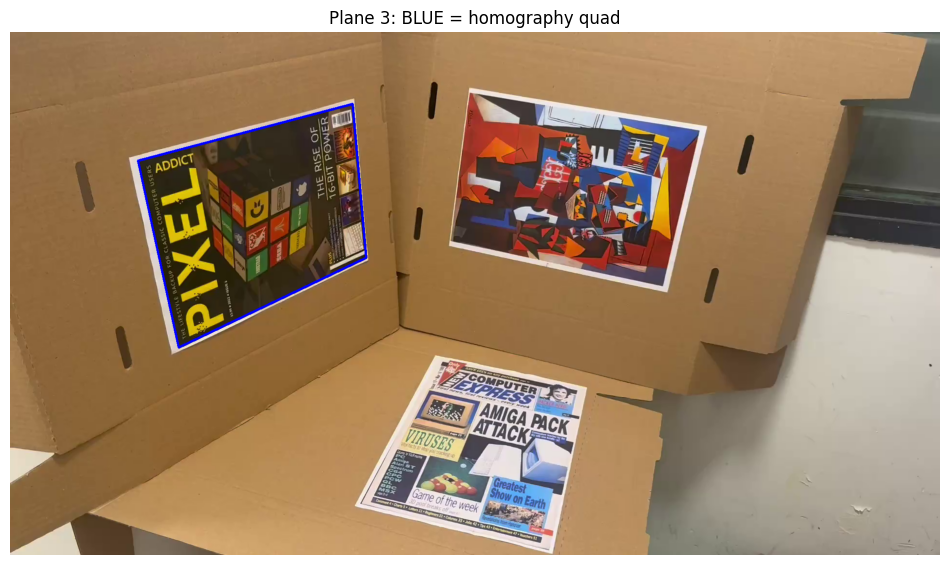

[C corners] ITERATIVE corner reproj err = 22.60px
[C corners] IPPE corner reproj err = 31.00px
[C inliers] ITERATIVE mean reproj err on inliers = 54.96px
[C inliers] IPPE mean reproj err on inliers = 55.73px


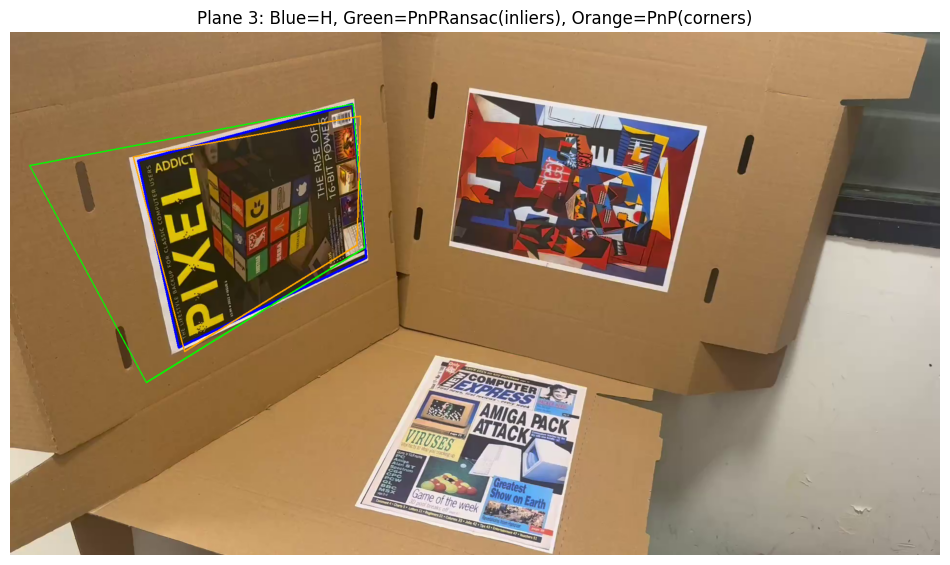

In [ ]:
# Cell 4: per-plane debug
# We run the pipeline in the exact order and show what each stage depends on.
#
# Blue  = homography corners (2D-only, from matching)
# Green = pose reprojection from INLIERS (solvePnPRansac)
# Orange= pose reprojection from 4 CORNERS (solvePnP)

RUN_IPPE = True  # try planar PnP variant as well


def pix_to_plane_xy(u: np.ndarray, v: np.ndarray, wR: int, hR: int, plane_w: float, plane_h: float):
    """Map reference pixel coords (u,v) to centered plane coords (x,y) on Z=0."""
    uu = u / float(max(1, wR - 1))
    vv = v / float(max(1, hR - 1))
    x = (uu - 0.5) * float(plane_w)
    y = (vv - 0.5) * float(plane_h)
    return x, y


def reproj_error(obj_pts, img_pts, rvec, tvec, K, dist):
    proj, _ = cv2.projectPoints(obj_pts, rvec, tvec, K, dist)
    proj = proj.reshape(-1, 2)
    return float(np.linalg.norm(proj - img_pts, axis=1).mean()), proj


def try_solvepnp(obj_pts, img_pts, K, dist, *, flag: int):
    try:
        ok, rvec, tvec = cv2.solvePnP(obj_pts, img_pts, K, dist, flags=int(flag))
    except cv2.error:
        return False, None, None
    if not ok:
        return False, None, None
    return True, rvec, tvec


def try_solvepnp_ransac(obj_pts, img_pts, K, dist, *, flag: int):
    try:
        ok, rvec, tvec, inl = cv2.solvePnPRansac(
            obj_pts,
            img_pts,
            K,
            dist,
            flags=int(flag),
            iterationsCount=300,
            reprojectionError=3.0,
            confidence=0.99,
        )
    except cv2.error:
        return False, None, None
    if not ok:
        return False, None, None
    return True, rvec, tvec


for i, ref in enumerate(refs, start=1):
    print("\n" + "=" * 60)
    print(f"Plane {i}")

    # --- A) Features & matching ---
    ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
    kp_ref, des_ref = det.detectAndCompute(ref_gray, None)
    if des_ref is None or kp_ref is None or len(kp_ref) < 20:
        print("[A] too few ref features")
        continue

    hR, wR = ref_gray.shape[:2]

    knn = bf.knnMatch(des_ref, des_fr, k=2)
    good = ratio_test(knn, float(cfg.ratio_test))
    print(f"[A] good matches = {len(good)}")
    if len(good) < int(cfg.min_matches):
        print(f"[A] stop: need >= {cfg.min_matches}")
        continue

    src = np.float32([kp_ref[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)  # ref pixels
    dst = np.float32([kp_fr[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)   # frame pixels

    # --- B) Homography (find plane in image) ---
    H, inlier_mask = cv2.findHomography(src, dst, cv2.RANSAC, float(cfg.ransac_reproj_thresh))
    if H is None or inlier_mask is None:
        print("[B] findHomography failed")
        continue

    inliers = int(inlier_mask.sum())
    print(f"[B] inliers = {inliers}/{len(good)}")
    if inliers < int(cfg.min_inliers):
        print(f"[B] stop: need >= {cfg.min_inliers}")
        continue

    ref_corners = np.float32([[0, 0], [wR - 1, 0], [wR - 1, hR - 1], [0, hR - 1]]).reshape(-1, 1, 2)
    corners_img = cv2.perspectiveTransform(ref_corners, H).reshape(4, 2).astype(np.float64)

    vis_h = frame.copy()
    cv2.polylines(vis_h, [corners_img.astype(int).reshape(-1, 1, 2)], True, (255, 0, 0), 3)
    show(vis_h, f"Plane {i}: BLUE = homography quad")

    # --- C) Pose estimation (solvePnP) ---
    # Build plane dimensions in world units (same convention as project)
    aspect = hR / float(wR)
    plane_w = float(cfg.plane_width)
    plane_h = plane_w * float(aspect)
    obj_corners = make_centered_obj_plane(plane_w, plane_h)  # 4 corners in 3D

    # C1) Pose from 4 corners (sensitive)
    ok_c_it, r_c_it, t_c_it = try_solvepnp(obj_corners, corners_img, K, dist, flag=cv2.SOLVEPNP_ITERATIVE)
    ok_c_ip, r_c_ip, t_c_ip = (False, None, None)
    if RUN_IPPE and hasattr(cv2, "SOLVEPNP_IPPE"):
        ok_c_ip, r_c_ip, t_c_ip = try_solvepnp(obj_corners, corners_img, K, dist, flag=cv2.SOLVEPNP_IPPE)

    # C2) Pose from MANY inlier correspondences (recommended)
    inl = inlier_mask.ravel().astype(bool)
    src_inl = src[inl].reshape(-1, 2)
    dst_inl = dst[inl].reshape(-1, 2).astype(np.float64)

    x, y = pix_to_plane_xy(src_inl[:, 0], src_inl[:, 1], wR, hR, plane_w, plane_h)
    obj_inl = np.stack([x, y, np.zeros_like(x)], axis=1).astype(np.float64)

    ok_i_it, r_i_it, t_i_it = try_solvepnp_ransac(obj_inl, dst_inl, K, dist, flag=cv2.SOLVEPNP_ITERATIVE)
    ok_i_ip, r_i_ip, t_i_ip = (False, None, None)
    if RUN_IPPE and hasattr(cv2, "SOLVEPNP_IPPE"):
        ok_i_ip, r_i_ip, t_i_ip = try_solvepnp_ransac(obj_inl, dst_inl, K, dist, flag=cv2.SOLVEPNP_IPPE)

    # Print errors so you can see what depends on what
    if ok_c_it:
        e, _ = reproj_error(obj_corners, corners_img, r_c_it, t_c_it, K, dist)
        print(f"[C corners] ITERATIVE corner reproj err = {e:.2f}px")
    else:
        print("[C corners] ITERATIVE failed")

    if ok_c_ip:
        e, _ = reproj_error(obj_corners, corners_img, r_c_ip, t_c_ip, K, dist)
        print(f"[C corners] IPPE corner reproj err = {e:.2f}px")
    elif RUN_IPPE:
        print("[C corners] IPPE failed/unavailable")

    if ok_i_it:
        e, _ = reproj_error(obj_inl, dst_inl, r_i_it, t_i_it, K, dist)
        print(f"[C inliers] ITERATIVE mean reproj err on inliers = {e:.2f}px")
    else:
        print("[C inliers] ITERATIVE failed")

    if ok_i_ip:
        e, _ = reproj_error(obj_inl, dst_inl, r_i_ip, t_i_ip, K, dist)
        print(f"[C inliers] IPPE mean reproj err on inliers = {e:.2f}px")
    elif RUN_IPPE:
        print("[C inliers] IPPE failed/unavailable")

    # Overlay: compare blue (H) vs green (inliers pose) vs orange (corners pose)
    vis = frame.copy()
    cv2.polylines(vis, [corners_img.astype(int).reshape(-1, 1, 2)], True, (255, 0, 0), 3)  # blue

    if ok_i_it:
        _, reproj_g = reproj_error(obj_corners, corners_img, r_i_it, t_i_it, K, dist)
        cv2.polylines(vis, [reproj_g.astype(int).reshape(-1, 1, 2)], True, (0, 255, 0), 2)  # green

    if ok_c_it:
        _, reproj_o = reproj_error(obj_corners, corners_img, r_c_it, t_c_it, K, dist)
        cv2.polylines(vis, [reproj_o.astype(int).reshape(-1, 1, 2)], True, (0, 165, 255), 2)  # orange

    show(vis, f"Plane {i}: Blue=H, Green=PnPRansac(inliers), Orange=PnP(corners)")



## Tips when results are not stable

- If **blue corners** are wrong: tighten matching (`ratio_test` smaller), increase `min_inliers`, or choose a better frame.
- If blue is good but **green (PnP reproj)** is far: check calibration file and ensure `K` is scaled to the video size.
- Try a different `FRAME_IDX` and compare inliers across planes.



In [ ]:
# NOTE
# IPPE testing was moved into Cell 4 (inside the per-plane loop).
# Toggle it there with:
#   RUN_IPPE = True / False
